In [1]:
# import wandb
# !wandb login

In [2]:
import torch
from torch.optim import Optimizer
from torch.nn import Parameter

from tqdm.notebook import tqdm
from typing import Iterator


# import sys
# sys.path.insert(1, "/kaggle/input/causal-mechanisms")

In [3]:
from model import *
from transformer import *
from dataset import *
from model import *
from optim import *
from trainer import *
from utils import *
from selector import *
from metrics import *

# directory for checkpoints
checkpt_dir = './checkpoints'
create_checkpoints_dir(checkpt_dir)

In [4]:
# settings
seed = 23435

num_experts = 2
input_size = 32 * 32

# initialization hyper-parameters
load_initialized_experts = True
expert_model_name = 'mnist_expert'


# discriminator hyper-parameters
discriminator_optimizer = 'adam'
discriminator_learning_rate = .001
discriminator_weight_decay = 0

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# training hyper-parameters
expert_optimizer = 'adam'
expert_learning_rate = .001
expert_weight_decay = 0

epochs = 1

In [5]:
chains = make_chains(candidates=all_transformers, of_sizes={1}, avoid_repetition=True, identity_detector=None)
chains

[Chain(su(x)), Chain(sr(x))]

In [6]:
# load dataset
train_loader, test_loader, train_dataset, test_dataset = load_datasets(seed=seed, data_dir="./data", chains=chains, batch_size=64)

In [7]:
# Losses
loss_training = torch.nn.L1Loss(reduction='none')
loss_discriminator = torch.nn.BCELoss(reduction='mean')

In [8]:
# train experts as approximately identity on transformed data
# initialize experts

experts = init_identity_experts(num_experts, checkpt_dir, expert_model_name, load_initialized_experts, device, train_loader)

In [9]:
# setup discriminator
discriminator = MnistDiscriminator().to(device)
discriminator.optimizer = create_optimizer(discriminator.parameters(), discriminator_optimizer, lr=discriminator_learning_rate, wd=discriminator_weight_decay)

torch.Size([1, 32, 32])
32


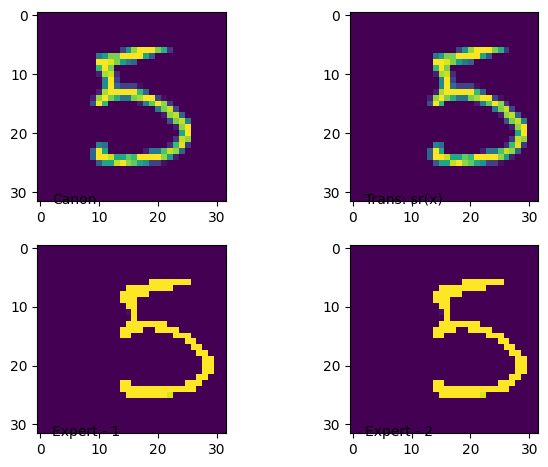

In [10]:
show_expert_demo(experts, test_dataset, 15, chains[1], device)

In [11]:
compositions = create_all_compositions(all_experts=experts, of_sizes={1}, avoid_repetition=True)
comp_names = [c.name for c in compositions]
comp_names

['e1(x)', 'e2(x)']

In [12]:
for expert in experts:
  expert.optimizer = create_optimizer(expert.parameters(), expert_optimizer, lr=expert_learning_rate, wd=expert_weight_decay)

In [13]:
# selector = GreedySelector(device, loss_training)
metrics = Metrics(len(compositions), len(chains))

for epoch in tqdm(range(epochs)):
    train_compositions_without_selector(
      input_size=input_size,
      criterion=loss_discriminator,
      device=device,
      discriminator=discriminator,
      experts=experts,
      compositions=compositions,
      data_train=train_loader,
      metrics=metrics
    )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Si

KeyboardInterrupt: ignored

In [ ]:
# for expert_index, expert in enumerate(experts):
#     torch.save(expert.state_dict(), checkpt_dir + f"/expert_{expert_index + 1}_trained.pth")
# torch.save(metrics, checkpt_dir + f"/metrics_trained.pth")

In [ ]:
show_compound(test_dataset, 41, chains, compositions, device)

In [ ]:
plot_hitmap(values=metrics.winners,
            title="Winner compositions",
            x_label="Compositions",
            y_label="Transformations",
            x_ticks=comp_names,
            y_ticks=chains,
            name=None)